In [2]:
from pyserini.search import LuceneSearcher, get_topics, get_qrels
from rank_gpt import run_retriever, sliding_windows, query_transformation
import tempfile
import json
from tqdm import tqdm
import pickle
import pandas as pd
openai_key = ''
gemini_key = ''
claude_key = ''
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\29097\.conda\envs\RankGPT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://github.com/ciralproject/ciral/blob/main/Guidelines/README.md#-trying-out-retrieval-with-cirals-dev-queries

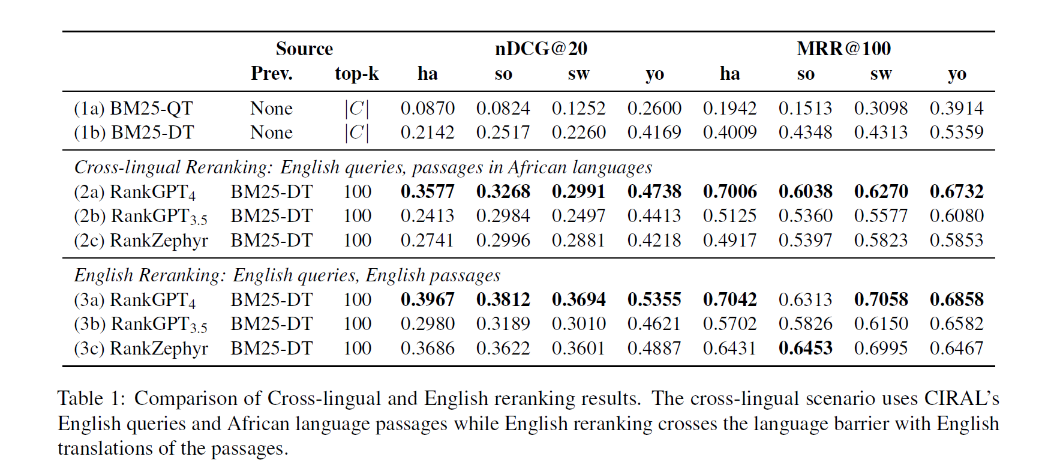

In [2]:
# python -m pyserini.search.lucene \
#   --language {lang} \
#   --topics tools/topics-and-qrels/topics.ciral-v1.0-{lang}-dev.tsv \
#   --index ciral-v1.0-{lang} \
#   --output runs/run.ciral-v1.0-{lang}.bm25.dev.txt \
#   --pretokenized \
#   --batch 128 --threads 16 --bm25 --hits 1000

In [3]:
import csv

def get_query(path):
    result_dict = {}
    with open(path, 'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter='\t')
        for row in reader:
            if len(row) == 2:
                key = int(row[0])
                title = row[1]
                result_dict[key] = {'title': title}
    return result_dict

In [4]:
# indexes
# https://github.com/castorini/pyserini/blob/master/docs/prebuilt-indexes.md

# from pyserini.search.lucene import LuceneSearcher
# LuceneSearcher.list_prebuilt_indexes()

# ciral-v1.0-ha
# ciral-v1.0-so
# ciral-v1.0-sw
# ciral-v1.0-yo
# ciral-v1.0-ha-en
# ciral-v1.0-so-en
# ciral-v1.0-sw-en
# ciral-v1.0-yo-en

# topics
# https://github.com/castorini/anserini-tools/tree/3a2b3cc5cfd915d707408aa5c4567185e9e4544f/topics-and-qrels


召回、保存召回结果

In [ ]:
# 进行retrieval
languages = [('ha', 'hausa'), ('so', 'somali'), ('sw', 'swahili'), ('yo', 'yoruba')]

for data, full_name in languages:
    # Retrieve passages using pyserini BM25.
    searcher = LuceneSearcher.from_prebuilt_index(f'ciral-v1.0-{data}-en')
    topics = get_query(f'./ciral/ciral/ciral-{full_name}/topics/topics.ciral-v1.0-{data}-dev.tsv')
    qrels = get_qrels(f'ciral-v1.0-{data}-dev')
    rank_results = run_retriever(topics, searcher, qrels, k=100)

    # 将召回的数据保存成csv
    df = pd.DataFrame(rank_results)
    df.to_csv(f'./run_retrieval/{data}-e2e-dev.csv', index=False)

    # 利用pickle保存召回的数据
    with open(f'./run_retrieval/{data}-e2e-dev.pkl', 'wb') as f:
        pickle.dump(rank_results, f)

In [ ]:
import tempfile

for data in ['ha','so','sw','yo']:
    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/{data}-e2e-test-a.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    # Evaluate nDCG@10
    from trec_eval import EvalFunction
    temp_file = tempfile.NamedTemporaryFile(delete=False).name
    EvalFunction.write_file(rank_results, temp_file)
    EvalFunction.main(f'{data}', temp_file)

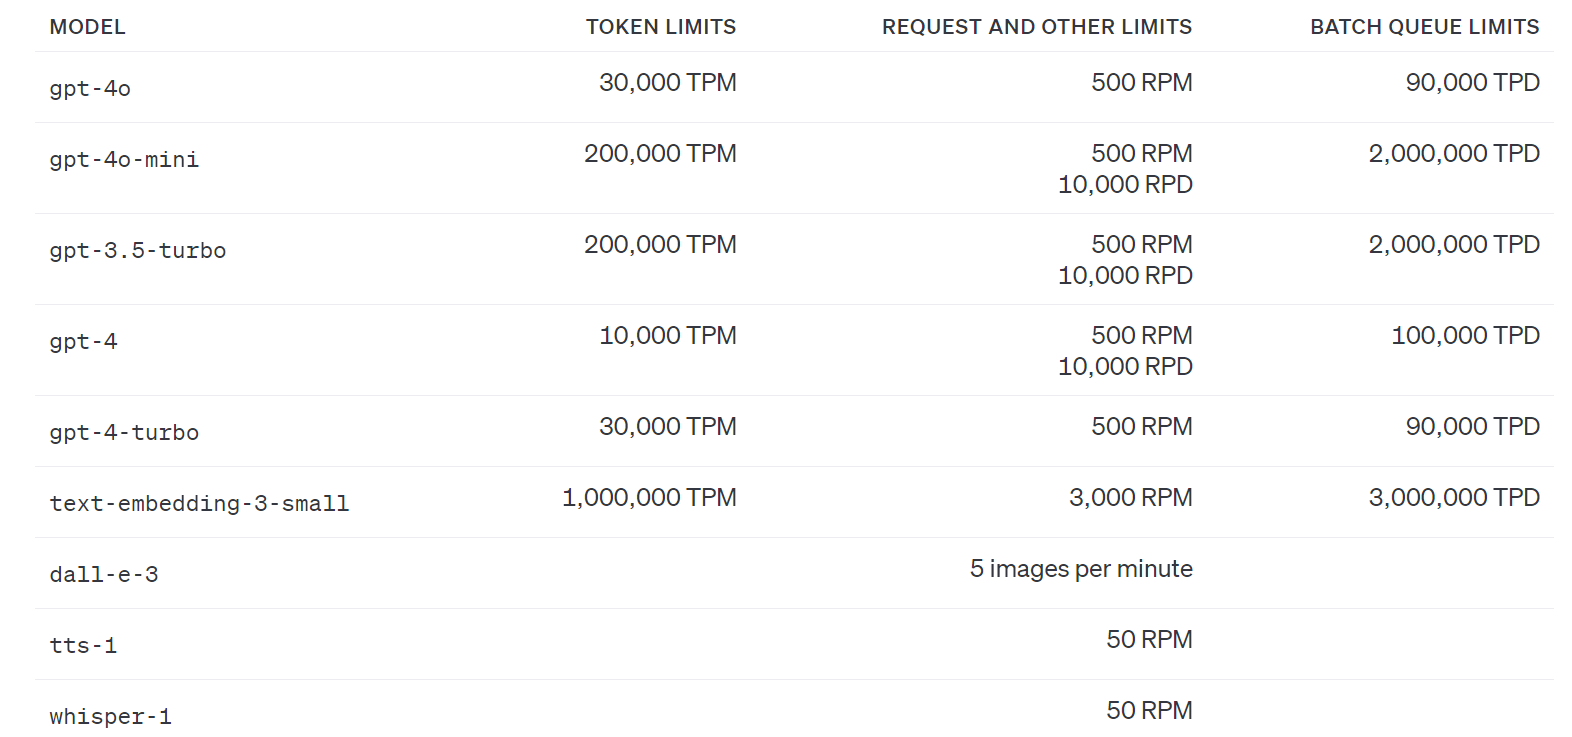

重排，保存重排结果

In [ ]:
import anthropic

client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=claude_key,
)
message = client.messages.create(
    model="claude-3-5-sonnet-20240620",
    max_tokens=1024,
    messages=[
        {"role": "user", "content": "Hello, Claude"}
    ]
)
print(message.content)

In [ ]:
# model_name = '4','4o','4omini'
model_name = 'claude-3-5-sonnet-20240620'
api_key_chosen = claude_key

# for data in ['ha','so','sw','yo']:
for data in ['sw','yo']:
    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/{data}-e2e-dev.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    new_results = []  # 存储处理后的新结果
    for item in tqdm(rank_results):  # tqdm用于显示进度条
        # item['query'] = query_transformation(item['query'])
        # 对每个检索结果item应用滑动窗口策略，参数包括窗口大小、步长等
        new_item = sliding_windows(item, rank_start=0, rank_end=100, window_size=20, step=10,
                                    model_name=model_name, api_key=api_key_chosen)
        new_results.append(new_item)  # 将处理后的结果添加到列表中

    # 将排序生成的数据保存成csv
    df = pd.DataFrame(new_results)
    df.to_csv(f'./run_reranking-{model_name}/{data}-e2e-dev.csv', index=False)

    # 利用pickle保存召回的数据
    with open(f'./run_reranking-{model_name}/{data}-e2e-dev.pkl', 'wb') as f:
        pickle.dump(new_results, f)

重排后评分对比

In [5]:
# for data in ['ha','so','sw','yo']:
for data in ['ha']:
    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_retrieval/{data}-e2e-dev.pkl', 'rb') as f:
        retrieval_results = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_reranking-3.5-turbo/{data}-e2e-dev.pkl', 'rb') as f:
        reranking_results1 = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_reranking-4o-mini/{data}-e2e-dev.pkl', 'rb') as f:
        reranking_results2 = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_reranking-4/{data}-e2e-dev.pkl', 'rb') as f:
        reranking_results3 = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_reranking-o1-mini/{data}-e2e-dev.pkl', 'rb') as f:
        reranking_results4 = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./run_reranking-claude-3-5-sonnet-20240620/{data}-e2e-dev.pkl', 'rb') as f:
        reranking_results5 = pickle.load(f)

    data = data + '-dev'
    for results in [retrieval_results, reranking_results1, reranking_results2, reranking_results3, reranking_results4, reranking_results5]:
        # 评估nDCG@10，即在前10个结果中的归一化折损累积增益
        from trec_eval import EvalFunction  # 导入评估函数模块

        # 创建一个临时文件来存储评估结果
        temp_file = tempfile.NamedTemporaryFile(delete=False).name
        # 将新的检索结果写入临时文件
        EvalFunction.write_file(results, temp_file)
        # 使用TREC评估工具执行评估，传入查询主题文件和结果文件
        EvalFunction.main(data, temp_file)
        print(data)

write_file
{'NDCG@1': 0.0, 'NDCG@5': 0.08304, 'NDCG@10': 0.09921, 'NDCG@20': 0.14542, 'MAP@1': 0.0, 'MAP@5': 0.02819, 'MAP@10': 0.0461, 'MAP@20': 0.06951, 'Recall@1': 0.0, 'Recall@5': 0.05, 'Recall@10': 0.11417, 'Recall@20': 0.21917}
mrr@100:0.1340423362327387
ha-dev
write_file
{'NDCG@1': 0.1, 'NDCG@5': 0.13836, 'NDCG@10': 0.13877, 'NDCG@20': 0.19675, 'MAP@1': 0.01667, 'MAP@5': 0.06264, 'MAP@10': 0.08123, 'MAP@20': 0.11009, 'Recall@1': 0.01667, 'Recall@5': 0.09, 'Recall@10': 0.125, 'Recall@20': 0.2575}
mrr@100:0.23905122655122651
ha-dev
write_file
{'NDCG@1': 0.1, 'NDCG@5': 0.19388, 'NDCG@10': 0.19654, 'NDCG@20': 0.22733, 'MAP@1': 0.02, 'MAP@5': 0.09764, 'MAP@10': 0.11867, 'MAP@20': 0.14173, 'Recall@1': 0.02, 'Recall@5': 0.155, 'Recall@10': 0.19, 'Recall@20': 0.25583}
mrr@100:0.307399910031489
ha-dev
write_file
{'NDCG@1': 0.0, 'NDCG@5': 0.20297, 'NDCG@10': 0.20395, 'NDCG@20': 0.23375, 'MAP@1': 0.0, 'MAP@5': 0.08865, 'MAP@10': 0.11338, 'MAP@20': 0.14633, 'Recall@1': 0.0, 'Recall@5': 0.16

In [ ]:
import tempfile

# Evaluate nDCG@10
from trec_eval import EvalFunction
temp_file = tempfile.NamedTemporaryFile(delete=False).name
EvalFunction.write_file(new_results, temp_file)
EvalFunction.main('ha', temp_file)

转变qrels的格式 tsv->txt

In [18]:
import csv

# 输入和输出文件路径
tsv_file = './ciral/ciral/ciral-yoruba/qrels/qrels.ciral-v1.0-yo-dev.tsv'
txt_file = './ciral/ciral/ciral-yoruba/qrels/qrels.ciral-v1.0-yo-dev.txt'

# 读取 TSV 文件并写入 TXT 文件
with open(tsv_file, 'r', newline='', encoding='utf-8') as infile, open(txt_file, 'w', encoding='utf-8') as outfile:
    reader = csv.reader(infile, delimiter='\t')
    for row in reader:
        # 将 TSV 的每一行转换为 TXT 文件的格式，通常是使用制表符分隔
        outfile.write('\t'.join(row) + '\n')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for data in ['ha','so','sw','yo']:
    # # 利用pickle打开保存成文件的召回的数据
    # with open(f'./retrieval_results/{data}.pkl', 'rb') as f:
    #     rank_results = pickle.load(f)

    # # 利用pickle打开保存成文件的排序后的数据
    # with open(f'./reranking_results/{data}.pkl', 'rb') as f:
    #     new_results = pickle.load(f)

    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/HT100_{data}.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    # # 利用pickle打开保存成文件的排序后的数据
    # with open(f'./reranking_results/{data}_gpted.pkl', 'rb') as f:
    #     new_results = pickle.load(f)

    # for results in [rank_results, new_results]:
    for results in [rank_results]:
        # 评估nDCG@10，即在前10个结果中的归一化折损累积增益
        from trec_eval import EvalFunction  # 导入评估函数模块

        # 创建一个临时文件来存储评估结果
        temp_file = tempfile.NamedTemporaryFile(delete=False).name
        # 将新的检索结果写入临时文件
        EvalFunction.write_file(results, temp_file)
        # 使用TREC评估工具执行评估，传入查询主题文件和结果文件
        EvalFunction.main(data, temp_file)

https://castorini.github.io/pyserini/2cr/ciral.html

In [ ]:
!python -m pyserini.search.lucene \
  --topics ciral-v1.0-ha-test-b \
  --index ciral-v1.0-ha-en \
  --output run.ciral.bm25-dt.ha.test-b.txt \
  --batch 128 --threads 16 --bm25 --hits 1000

In [ ]:
!python -m pyserini.eval.trec_eval \
  -c -m ndcg_cut.20 ciral-v1.0-ha-test-b \
  run.ciral.bm25-dt.ha.test-b.txt

In [ ]:
# 进行retrieval
# Retrieve passages using pyserini BM25.
searcher = LuceneSearcher('/root/autodl-fs/indexes/zho-collection_index')
searcher.set_language('zh')
topics = get_query('/root/autodl-fs/queries/queries_zho_googltrans.json')
qrels = get_qrel('/root/autodl-fs/qrels/qrels_perfected/qrels_final_zho.json')
rank_results = run_retriever(topics, searcher, qrels, k=100)

# 将召回的数据保存成csv
df = pd.DataFrame(rank_results)
df.to_csv('/root/autodl-fs/run_retrieval/HT100_zho.csv', index=False)

# 利用pickle保存召回的数据
with open('/root/autodl-fs/run_retrieval/HT100_zho.pkl', 'wb') as f:
    pickle.dump(rank_results, f)

In [ ]:
# 进行retrieval
# Retrieve passages using pyserini BM25.
searcher = LuceneSearcher('/root/autodl-fs/indexes/fas-collection_index')
searcher.set_language('fa')
topics = get_query('/root/autodl-fs/queries/queries_fas_googltrans.json')
qrels = get_qrel('/root/autodl-fs/qrels/qrels_perfected/qrels_final_fas.json')
rank_results = run_retriever(topics, searcher, qrels, k=100)

# 将召回的数据保存成csv
df = pd.DataFrame(rank_results)
df.to_csv('/root/autodl-fs/run_retrieval/HT100_fas.csv', index=False)

# 利用pickle保存召回的数据
with open('/root/autodl-fs/run_retrieval/HT100_fas.pkl', 'wb') as f:
    pickle.dump(rank_results, f)

In [ ]:
# 进行retrieval
# Retrieve passages using pyserini BM25.
searcher = LuceneSearcher('/root/autodl-fs/indexes/rus-collection_index')
searcher.set_language('ru')
topics = get_query('/root/autodl-fs/queries/queries_rus_googltrans.json')
qrels = get_qrel('/root/autodl-fs/qrels/qrels_perfected/qrels_final_rus.json')
rank_results = run_retriever(topics, searcher, qrels, k=100)

# 将召回的数据保存成csv
df = pd.DataFrame(rank_results)
df.to_csv('/root/autodl-fs/run_retrieval/HT100_rus.csv', index=False)

# 利用pickle保存召回的数据
with open('/root/autodl-fs/run_retrieval/HT100_rus.pkl', 'wb') as f:
    pickle.dump(rank_results, f)

In [ ]:
rank_results[0]['hits'][1]

#### 重排前评分

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for data in ['zho','fas','rus']:
    # # 利用pickle打开保存成文件的召回的数据
    # with open(f'./retrieval_results/{data}.pkl', 'rb') as f:
    #     rank_results = pickle.load(f)

    # # 利用pickle打开保存成文件的排序后的数据
    # with open(f'./reranking_results/{data}.pkl', 'rb') as f:
    #     new_results = pickle.load(f)

    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/HT100_{data}.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    # # 利用pickle打开保存成文件的排序后的数据
    # with open(f'./reranking_results/{data}_gpted.pkl', 'rb') as f:
    #     new_results = pickle.load(f)

    # for results in [rank_results, new_results]:
    for results in [rank_results]:
        # 评估nDCG@10，即在前10个结果中的归一化折损累积增益
        from trec_eval import EvalFunction  # 导入评估函数模块

        # 创建一个临时文件来存储评估结果
        temp_file = tempfile.NamedTemporaryFile(delete=False).name
        # 将新的检索结果写入临时文件
        EvalFunction.write_file(results, temp_file)
        # 使用TREC评估工具执行评估，传入查询主题文件和结果文件
        EvalFunction.main(data, temp_file)

#### 重排后评分

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for data in ['zho','fas','rus']:
    # # 利用pickle打开保存成文件的召回的数据
    # with open(f'./retrieval_results/{data}.pkl', 'rb') as f:
    #     rank_results = pickle.load(f)

    # # 利用pickle打开保存成文件的排序后的数据
    # with open(f'./reranking_results/{data}.pkl', 'rb') as f:
    #     new_results = pickle.load(f)

    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/HT100_{data}.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./reranking_results/{data}.pkl', 'rb') as f:
        new_results = pickle.load(f)

    # 利用pickle打开保存成文件的排序后的数据
    with open(f'./reranking_results/{data}_queryexpand.pkl', 'rb') as f:
        new_qe_results = pickle.load(f)

    # for results in [rank_results, new_results]:
    for results in [rank_results, new_results, new_qe_results]:
        # 评估nDCG@10，即在前10个结果中的归一化折损累积增益
        from trec_eval import EvalFunction  # 导入评估函数模块

        # 创建一个临时文件来存储评估结果
        temp_file = tempfile.NamedTemporaryFile(delete=False).name
        # 将新的检索结果写入临时文件
        EvalFunction.write_file(results, temp_file)
        # 使用TREC评估工具执行评估，传入查询主题文件和结果文件
        EvalFunction.main(data, temp_file)

重排的过程

In [ ]:
# for data in ['zho','fas','rus']:
for data in ['rus']:
    # 利用pickle打开保存成文件的召回的数据
    with open(f'./run_retrieval/HT100_{data}_trunc.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    print("对检索结果应用滑动窗口排列生成策略")
    # 对检索结果应用滑动窗口排列生成策略
    new_results = []  # 存储处理后的新结果
    for item in tqdm(rank_results):  # tqdm用于显示进度条
        # item['query'] = query_transformation(item['query'])
        # 对每个检索结果item应用滑动窗口策略，参数包括窗口大小、步长等
        new_item = sliding_windows(item, rank_start=0, rank_end=100, window_size=20, step=10,
                                   model_name='gpt-3.5-turbo', api_key=openai_key)
        new_results.append(new_item)  # 将处理后的结果添加到列表中

    # 将排序生成的数据保存成csv
    df = pd.DataFrame(new_results)
    df.to_csv(f'./reranking_results/{data}_.csv', index=False)

    # 利用pickle保存召回的数据
    with open(f'./reranking_results/{data}_.pkl', 'wb') as f:
        pickle.dump(new_results, f)

In [ ]:
len(new_results)

In [ ]:
# 将排序生成的数据保存成csv
df = pd.DataFrame(new)
df.to_csv(f'./reranking_results/{data}_queryexpand_63.csv', index=False)

# 利用pickle保存召回的数据
with open(f'./reranking_results/{data}_queryexpand_63.pkl', 'wb') as f:
    pickle.dump(new, f)

In [ ]:
len(rank_results[63:])

In [ ]:
new_results[62]

In [ ]:
new = new_results

In [ ]:
len(new)

In [ ]:
import os
os.environ['PATH'] = '/root/jvm/jdk-21.0.3/bin:/root/maven/apache-maven-3.9.7/bin:/root/miniconda3/bin:/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin'

from rank_gpt import run_retriever, sliding_windows, write_eval_file
from pyserini.search import LuceneSearcher, get_topics, get_qrels
from tqdm import tqdm
import tempfile
import os
import json
import shutil
import pandas as pd
import pickle

openai_key = '' 

In [ ]:
# for data in ['dl19', 'dl20', 'covid', 'nfc', 'touche', 'dbpedia', 'scifact', 'signal', 'news',]:
for data in ['signal_gpted']:
    # 利用pickle打开保存成文件的召回的数据
    with open(f'./retrieval_results/{data}.pkl', 'rb') as f:
        rank_results = pickle.load(f)

    print("对检索结果应用滑动窗口排列生成策略")
    # 对检索结果应用滑动窗口排列生成策略
    new_results = []  # 存储处理后的新结果
    for item in tqdm(rank_results):  # tqdm用于显示进度条
        # 对每个检索结果item应用滑动窗口策略，参数包括窗口大小、步长等
        new_item = sliding_windows(item, rank_start=0, rank_end=100, window_size=20, step=10,
                                   model_name='gpt-3.5-turbo', api_key=openai_key)
        new_results.append(new_item)  # 将处理后的结果添加到列表中

    # 将排序生成的数据保存成csv
    df = pd.DataFrame(new_results)
    df.to_csv(f'./reranking_results/{data}.csv', index=False)

    # 利用pickle保存召回的数据
    with open(f'./reranking_results/{data}.pkl', 'wb') as f:
        pickle.dump(new_results, f)

In [ ]:
item = {
    'query': 'How much impact do masks have on preventing the spread of the COVID-19?',
    'hits': [
        {'content': 'Title: Universal Masking is Urgent in the COVID-19 Pandemic: SEIR and Agent Based Models, Empirical Validation, Policy Recommendations Content: We present two models for the COVID-19 pandemic predicting the impact of universal face mask wearing upon the spread of the SARS-CoV-2 virus--one employing a stochastic dynamic network based compartmental SEIR (susceptible-exposed-infectious-recovered) approach, and the other employing individual ABM (agent-based modelling) Monte Carlo simulation--indicating (1) significant impact under (near) universal masking when at least 80% of a population is wearing masks, versus minimal impact when only 50% or less of the population is wearing masks, and (2) significant impact when universal masking is adopted early, by Day 50 of a regional outbreak, versus minimal impact when universal masking is adopted late. These effects hold even at the lower filtering rates of homemade masks. To validate these theoretical models, we compare their predictions against a new empirical data set we have collected'},
        {'content': 'Title: Masking the general population might attenuate COVID-19 outbreaks Content: The effect of masking the general population on a COVID-19 epidemic is estimated by computer simulation using two separate state-of-the-art web-based softwares, one of them calibrated for the SARS-CoV-2 virus. The questions addressed are these: 1. Can mask use by the general population limit the spread of SARS-CoV-2 in a country? 2. What types of masks exist, and how elaborate must a mask be to be effective against COVID-19? 3. Does the mask have to be applied early in an epidemic? 4. A brief general discussion of masks and some possible future research questions regarding masks and SARS-CoV-2. Results are as follows: (1) The results indicate that any type of mask, even simple home-made ones, may be effective. Masks use seems to have an effect in lowering new patients even the protective effect of each mask (here dubbed"one-mask protection") is'},
        {'content': 'Title: To mask or not to mask: Modeling the potential for face mask use by the general public to curtail the COVID-19 pandemic Content: Face mask use by the general public for limiting the spread of the COVID-19 pandemic is controversial, though increasingly recommended, and the potential of this intervention is not well understood. We develop a compartmental model for assessing the community-wide impact of mask use by the general, asymptomatic public, a portion of which may be asymptomatically infectious. Model simulations, using data relevant to COVID-19 dynamics in the US states of New York and Washington, suggest that broad adoption of even relatively ineffective face masks may meaningfully reduce community transmission of COVID-19 and decrease peak hospitalizations and deaths. Moreover, mask use decreases the effective transmission rate in nearly linear proportion to the product of mask effectiveness (as a fraction of potentially infectious contacts blocked) and coverage rate (as'}
    ]
}

In [ ]:
from rank_gpt import permutation_pipeline
new_item = permutation_pipeline(item, rank_start=0, rank_end=3, model_name='gpt-3.5-turbo', api_key='sk-epNZrNS7qVWtdCCcEa47C809A94d4399924454B46dC73671')
print(new_item)

In [ ]:
searcher = LuceneSearcher('/root/autodl-fs/indexes/zho-collection_index/')
searcher.set_language('zh')
hits = searcher.search('体育中是否存在机构腐败和贿赂的案例？')

for i in range(0, 10):
    print(f'{i+1:2} {hits[i].docid:7} {hits[i].score:.5f}')

In [ ]:
import csv
import json

# 定义输入和输出文件路径
input_file = '/root/autodl-fs/queries/queries_fas_humantrans.tsv'
output_file = '/root/autodl-fs/queries/queries_fas_humantrans.json'

# 初始化一个空字典用于存储结果
result = {}

# 读取TSV文件并处理每一行
with open(input_file, 'r', encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
        if len(row) < 2:
            continue
        id = int(row[0].strip())
        title = row[1].strip()
        result[id] = {'title': title}

# 将结果字典写入JSON文件
with open(output_file, 'w', encoding='utf-8') as jsonfile:
    json.dump(result, jsonfile, indent=2, ensure_ascii=False)

print(f"数据已成功写入 {output_file}")

In [ ]:
import csv
import json

# 定义输入和输出文件路径
input_file = '/root/autodl-fs/qrels/qrels_perfected/qrels_final_rus.tsv'
output_file = '/root/autodl-fs/qrels/qrels_perfected/qrels_final_rus.json'

# 初始化一个空字典用于存储结果
result = {}

with open(input_file, mode='r') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for line in reader:
        row = line[0].split()
        query_id = int(row[0])
        doc_id = row[2]
        score = row[3]
        
        if query_id not in result:
            result[query_id] = {}
        result[query_id][doc_id] = score

# 将结果字典写入 JSON 文件
with open(output_file, 'w', encoding='utf-8') as jsonfile:
    json.dump(result, jsonfile, ensure_ascii=False, indent=4)

print(f"TSV 文件已成功转换并保存到 JSON 文件：{output_file}")

In [ ]:
# # rank_results格式
# for data in ['dl19']:
#     # 利用pickle打开保存成文件的召回的数据
#     with open(f'./retrieval_results/{data}.pkl', 'rb') as f:
#         rank_results = pickle.load(f)

# # print(rank_results[0])

In [ ]:
def run_retriever(topics, searcher, qrels=None, k=100, qid=None):
    ranks = []
    if isinstance(topics, str):
        hits = searcher.search(topics, k=k)
        ranks.append({'query': topics, 'hits': []})
        rank = 0
        for hit in hits:
            rank += 1
            content = json.loads(searcher.doc(hit.docid).raw())
            if 'title' in content:
                content = 'Title: ' + content['title'] + ' ' + 'Content: ' + content['text']
            else:
                content = content['contents']
            content = ' '.join(content.split())
            ranks[-1]['hits'].append({
                'content': content,
                'qid': qid, 'docid': hit.docid, 'rank': rank, 'score': hit.score})
        return ranks[-1]

    for qid in tqdm(topics):
        if qid in qrels:
            query = topics[qid]['title']
            ranks.append({'query': query, 'hits': []})
            hits = searcher.search(query, k=k)
            rank = 0
            for hit in hits:
                rank += 1
                content = json.loads(searcher.doc(hit.docid).raw())
                if 'title' in content:
                    content = 'Title: ' + content['title'] + ' ' + 'Content: ' + content['text']
                else:
                    content = content['contents']
                content = ' '.join(content.split())
                ranks[-1]['hits'].append({
                    'content': content,
                    'qid': qid, 'docid': hit.docid, 'rank': rank, 'score': hit.score})
    return ranks